#Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from numpy.random import randint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from google.colab.patches import cv2_imshow
import tensorflow_datasets as tfdas
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer
!wget https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0
!unzip /content/mnistTask3.zip?dl=0

# Setting Data hyperparameters and reshaping it

In [ ]:
input_shape=(28,28,1)
classes=10
dicti={}

In [ ]:
def bounder(thresh,margin=12):
  sh=thresh.shape
  x_min,x_max,y_min,y_max=10000,-10000,10000,-10000
  for x in range(sh[0]):
    if np.amax(thresh[x])!=0: x_min,x_max=min(x_min,x),max(x_max,x)
  for y in range(sh[1]):
    if np.amax(thresh.T[y])!=0: y_min,y_max=min(y_min,y),max(y_max,y)
  return thresh[max(x_min-margin,0):min(x_max+margin,sh[1]),max(y_min-margin,0):min(y_max+margin,sh[1])]

## Preprocessing
1. Load image resphape it trim pixels from boundry and then again resize it

In [ ]:
j,X,Y = 0,[],[]
for foldername in os.listdir("/content/mnistTask"):
  for filename in os.listdir("/content/mnistTask/"+str(foldername)):
    filepath="/content/mnistTask/"+str(foldername)+"/"+str(filename)
    image=cv2.imread(filepath)
    thresh = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255
    thresh=cv2.resize(thresh,(28,28))
    thresh=bounder(thresh,2)
    thresh=cv2.resize(thresh,(28,28))
    X.append(thresh)
    vec=np.zeros(classes)
    dicti[int(foldername)]=thresh
    vec[int(foldername)]=1
    Y.append(vec)
X=np.expand_dims(np.array(X),3)
Y=np.array(Y)
print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.33)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=False)
datagen.fit(X_train)

(60000, 28, 28, 1) (60000, 10)
(40200, 28, 28, 1) (40200, 10) (19800, 28, 28, 1) (19800, 10)


#View Sample images

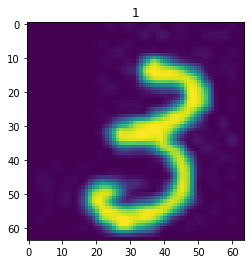

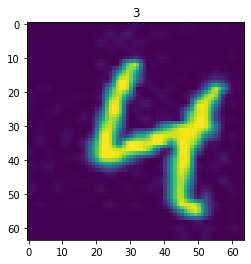

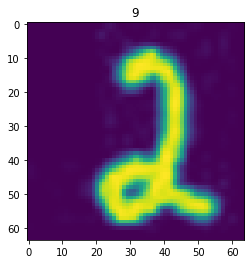

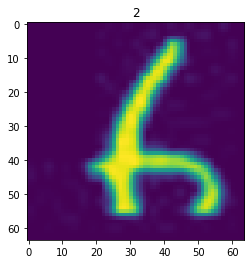

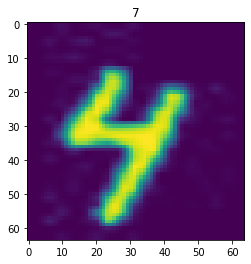

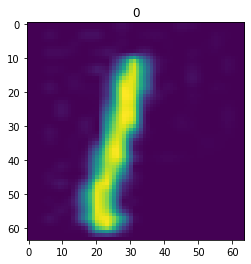

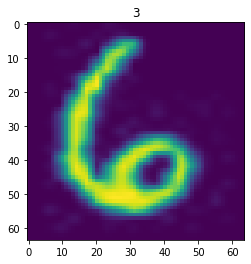

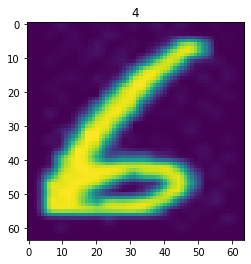

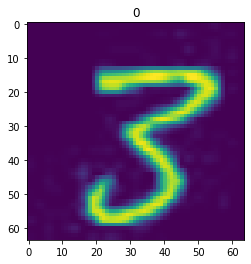

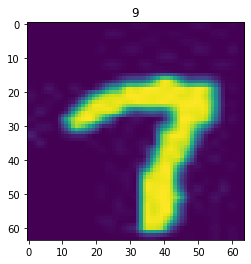

In [ ]:
def disp(img,vec):
  plt.figure()
  plt.imshow(img[:,:,0])
  plt.title(str(np.argmax(vec)))
for i in random.sample(range(0, X.shape[0]), 10):
  disp(X[i],Y[i])

It can be seen that the labels corresponding to each image is what the image is not, hence essentially the neural netowrk will ouput a probability vector of P of 10 dimensoions, where P[i] corresponds to the probability of the image not being the ith digit.
Hence for inference we will take the minimum output probability. For testing we will test it on MNIST dataset

In [ ]:
def onehot(y):
  num_labels=np.size(np.unique(y))
  Y = np.zeros((y.shape[0],num_labels))
  for i in range(y.shape[0]):
    Y[i][y[i]]=1
  return Y
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data(path='mnist.npz')
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
x_test,x_train,y_test,y_train=np.expand_dims(np.array(x_test/255),3),np.expand_dims(np.array(x_train/255),3),onehot(y_test),onehot(y_train)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


# Training a randomly inittialized CNN: Learning objective is to maximize the output corresponding to all the digits except input digit

* While calculating the accuracy we take the argmin of predictions

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
          rotation_range=30,
          horizontal_flip=False)
datagen.fit(X_train)
training =True
def CustomCNN_arch(input_shape = (64, 64, 1), classes = 10):
  model = tf.keras.Sequential([
  Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = input_shape),
  Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),  
  BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25), 
  Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
  Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
  BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25),
  Flatten(name = 'flatten'),
  Dense(units = 256), BatchNormalization(), Activation("relu"),  
  Dense(units = 128), BatchNormalization(), Activation("relu"),
  Dropout(0.25),
  Dense(units = classes, activation = 'softmax')])
  return model
if training:
  model = CustomCNN_arch(input_shape = input_shape, classes = classes)
  model.compile(optimizer='adam', loss='categorical_crossentropy',run_eagerly=True)
  for i in range(20):
    print('Epoch number: {}'.format(i))
    model.fit(datagen.flow(X_train, Y_train, batch_size=32),
              steps_per_epoch=len(X_train) / 32, epochs=1)
    model.save_weights('Weight_number: {}.h5'.format(i))
    print('Performance on MNIST test data:' ,accuracy_score(np.argmax(y_test,-1),np.argmin(model.predict(x_test),-1)))     

Epoch number: 0
1256/1256 [==============================] - 73s 58ms/step - loss: 2.4685
Performance on MNIST test data: 0.5291
Epoch number: 1
1256/1256 [==============================] - 73s 58ms/step - loss: 2.2974
Performance on MNIST test data: 0.5735
Epoch number: 2
1256/1256 [==============================] - 73s 58ms/step - loss: 2.2818
Performance on MNIST test data: 0.7491
Epoch number: 3
1256/1256 [==============================] - 74s 59ms/step - loss: 2.2697
Performance on MNIST test data: 0.6785
Epoch number: 4
1256/1256 [==============================] - 73s 58ms/step - loss: 2.2601
Performance on MNIST test data: 0.7881
Epoch number: 5
1256/1256 [==============================] - 73s 58ms/step - loss: 2.2531
Performance on MNIST test data: 0.827
Epoch number: 6
1256/1256 [==============================] - 72s 58ms/step - loss: 2.2453
Performance on MNIST test data: 0.8297
Epoch number: 7
1256/1256 [==============================] - 72s 58ms/step - loss: 2.2422
Performa

###Loading best weight and evaluating on test dataset
- Above netowrk reaches maximum accuracy in 13th epoch
- While calculating accuracy , we take argmin of the predictions

In [ ]:
model = CustomCNN_arch(input_shape = input_shape, classes = classes)
model.load_weights('/content/Weight_number: 13.h5')
print('Final Test accuracy on MNIST', accuracy_score(np.argmax(y_test,-1),np.argmin(model.predict(x_test),-1)))

Final Test accuracy on MNIST 0.9542


# Loading pretrained network trained on 0-9 images of custom dataset and then training it on this dataset

###Loading pretrained model trained on custom dataset and training it on this dataset
* The model whose weights is being loaded has been trained on custom datasets digits 0-9 with an input size of 28x28, find the corresponding notebook in Midas_Task2/Point 3/ directory

In [ ]:
!wget https://github.com/mh2029/Midas_Task2/blob/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5?raw=true


--2021-04-10 16:24:23--  https://github.com/mh2029/Midas_Task2/blob/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mh2029/Midas_Task2/raw/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5 [following]
--2021-04-10 16:24:24--  https://github.com/mh2029/Midas_Task2/raw/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5 [following]
--2021-04-10 16:24:24--  https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5
Resolvin

In [ ]:
ptmodel = CustomCNN_arch(input_shape = input_shape, classes = classes)
!wget https://github.com/mh2029/Midas_Task2/blob/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5?raw=true
ptmodel.load_weights('/content/task3_customdata_029_size28x28_customCnn.hdf5?raw=true')
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',run_eagerly=True)
for i in range(20):
  print('Epoch number: {}'.format(i))
  ptmodel.fit(datagen.flow(X_train, Y_train, batch_size=32),
            steps_per_epoch=len(X_train) / 32, epochs=1)
  ptmodel.save_weights('/content/pt/number: {}.h5'.format(i))
  print('Performance on MNIST test data:' ,accuracy_score(np.argmax(y_test,-1),np.argmin(ptmodel.predict(x_test),-1)))     

--2021-04-10 16:47:58--  https://github.com/mh2029/Midas_Task2/blob/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mh2029/Midas_Task2/raw/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5 [following]
--2021-04-10 16:47:58--  https://github.com/mh2029/Midas_Task2/raw/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5 [following]
--2021-04-10 16:47:59--  https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Misc_weights/task3_customdata_029_size28x28_customCnn.hdf5
Resolvin

###Final performance of pretrained model on MNIST test dataset
- Weight download from ``weights/Important_weights/point3_pretrained.h5``

In [ ]:
!wget https://github.com/mh2029/Midas_Task2/blob/main/Weights/Important_weights/point3_pretrained.h5?raw=true
ptmodel.load_weights('/content/point3_pretrained.h5?raw=true')
print('Final Test accuracy on MNIST', accuracy_score(np.argmax(y_test,-1),np.argmin(ptmodel.predict(x_test),-1)))

--2021-04-10 17:21:34--  https://github.com/mh2029/Midas_Task2/blob/main/Weights/Important_weights/point3_pretrained.h5?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mh2029/Midas_Task2/raw/main/Weights/Important_weights/point3_pretrained.h5 [following]
--2021-04-10 17:21:34--  https://github.com/mh2029/Midas_Task2/raw/main/Weights/Important_weights/point3_pretrained.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Important_weights/point3_pretrained.h5 [following]
--2021-04-10 17:21:34--  https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Important_weights/point3_pretrained.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199

### It can be seen that a final test accuracy is 96.14% whicih is quite good, since the dataset has a different learning perspective

It can be seen that there isnt much help from a pretrained network. This can be owed to the different learning objective

This dataset is quite intresting, here the labels do not correspond to what the digit's image is but rather what it is not, so the 0th folder/images with label 0 are all the digits except 0!

- on comparing to the initial custom dataset of point 1 there are quite a few differences
- The image is 28x28 in dimenstion compared to 900x1080 of custom dataset
- Here images pixel values are between 0-255, compared to 0-1(normalzed in custom dataset)
- Here the image is negative of custom dataset, that is foreground is white while background is black

- Also here we have many training examples, large dataset size compared to only 40 examples per class in custom dataset

- The meaning of folder name in each corresponds to different meanings as alread discussed
The netowrk is trained, with the learning objective to maximize the output for all the complement classes, hence the actual prediction is the output probability with minimum value.